#This adds in simple visual to see top entites and nodes

In [34]:
import json
import csv
import logging
import os
import re
from io import BytesIO
from rapidfuzz import fuzz
# pdfminer for PDF extraction
from pdfminer.high_level import extract_text as pdf_extract_text
from collections import Counter
import phonenumbers


In [35]:
# AzureOpenAI
from openai import AzureOpenAI

In [36]:
AZURE_API_KEY = "9abc905da5104e8eb8d6ec3ceb27f767"  # Replace with your API key
AZURE_ENDPOINT = "https://aoai.apim.mitre.org/api-key"  # Replace with your endpoint
API_VERSION = "2023-03-15-preview"

In [37]:
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsNERTagger, Doc


In [38]:
# Initialize Natasha components
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /Users/bdowns/.pyenv/versions/tflima_3.12.0_env/lib/python3.12/site-packages/pymorphy2_dicts_ru/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [39]:
# For visualization
import matplotlib.pyplot as plt
import networkx as nx

In [40]:
# Logging Configuration
# ---------------------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [41]:
# Validation Functions
# ---------------------------------------
def is_valid_ip(ip):
    pattern = r"^(25[0-5]|2[0-4]\d|[01]?\d?\d)\." \
              r"(25[0-5]|2[0-4]\d|[01]?\d?\d)\." \
              r"(25[0-5]|2[0-4]\d|[01]?\d?\d)\." \
              r"(25[0-5]|2[0-4]\d|[01]?\d?\d)$"
    if re.match(pattern, ip.strip()):
        return True
    if ":" in ip.strip():  # Basic IPv6 check
        return True
    return False

def is_valid_email(email):
    pattern = r"^[^@\s]+@[^@\s]+\.[^@\s]+$"
    return bool(re.match(pattern, email.strip()))

def is_valid_phone_number(phone_str):
    try:
        parsed = phonenumbers.parse(phone_str, None)
        return phonenumbers.is_valid_number(parsed)
    except phonenumbers.NumberParseException:
        return False

def is_valid_iban(iban):
    # Original naive check; IBAN processing removed as per your request.
    iban = iban.replace(" ", "")
    return 15 <= len(iban) <= 34

In [42]:
# PDF Extraction & Cleaning
# ---------------------------------------
def extract_text_from_pdf(pdf_file_path):
    try:
        text = pdf_extract_text(pdf_file_path)
        logger.info(f"Extracted {len(text)} characters from PDF.")
        return text
    except Exception as e:
        logger.error(f"Error extracting text from {pdf_file_path}: {e}")
        return ""

def clean_text(text):
    if not text:
        return ""
    cleaned_text = text.replace('\n', ' ').replace('\r', ' ')
    return ' '.join(cleaned_text.split())

def chunk_text(text, max_chars=2000):
    chunks = []
    start = 0
    while start < len(text):
        end = start + max_chars
        chunks.append(text[start:end])
        start = end
    logger.info(f"Divided text into {len(chunks)} chunks.")
    logger.debug(f"First chunk preview: {chunks[0][:200]}")
    return chunks

In [43]:
# Azure OpenAI Call
# ---------------------------------------
def call_azure_openai_api(prompt, openai_client, model_name="gpt35-turbo-16k"):
    response = openai_client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are an AI that extracts and normalizes entities/relationships from text."},
            {"role": "user", "content": prompt},
        ],
        temperature=0
    )
    if response.choices:
        result = response.choices[0].message.content.strip()
        logger.debug(f"API raw response: {result}")
        return result
    else:
        logger.error("No response from Azure OpenAI.")
        return ""


In [44]:
# Russian NER with Natasha
# ---------------------------------------
def detect_russian_entities(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    russian_names = set()
    russian_companies = set()
    for span in doc.spans:
        span.normalize(morph_vocab)
        if span.type == 'PER':
            russian_names.add(span.text)
        elif span.type == 'ORG':
            russian_companies.add(span.text)
    logger.debug(f"Natasha detected {len(russian_names)} person names and {len(russian_companies)} organizations.")
    return russian_names, russian_companies

def combine_entities(llm_entities, text):
    rus_names, rus_companies = detect_russian_entities(text)
    llm_entities["person_names"] = list(set(llm_entities.get("person_names", [])) | rus_names)
    llm_entities["company_names"] = list(set(llm_entities.get("company_names", [])) | rus_companies)
    return llm_entities


In [45]:
# Entity Extraction & Validation (LLM + Natasha)
# ---------------------------------------
def extract_entities_from_chunk(text_chunk, openai_client):
    prompt = f"""
Extract the following entities from the text below:
- IP addresses
- Emails
- Company names
- Person names
- IBANs

Return them as valid JSON in the format:
{{
    "ip_addresses": [],
    "emails": [],
    "company_names": [],
    "person_names": [],
    "ibans": []
}}

If you see no valid data for a category, leave that list empty.

Text to analyze:
{text_chunk}
    """
    logger.debug("Extracting entities from chunk...")
    response_text = call_azure_openai_api(prompt, openai_client)
    logger.debug(f"Raw API response for entities: {response_text}")
    try:
        entities = json.loads(response_text)
    except (json.JSONDecodeError, TypeError) as e:
        logger.error(f"Failed to parse JSON for entities: {e}. Response was: {response_text}")
        return {}
    
    ip_addresses = [ip for ip in entities.get("ip_addresses", []) if is_valid_ip(ip)]
    emails = [em for em in entities.get("emails", []) if is_valid_email(em)]
    # Keep IBANs even though we may not use them heavily.
    ibans = [iban for iban in entities.get("ibans", []) if is_valid_iban(iban)]
    companies = entities.get("company_names", [])
    persons = entities.get("person_names", [])
    
    combined = {
        "ip_addresses": ip_addresses,
        "emails": emails,
        "company_names": companies,
        "person_names": persons,
        "ibans": ibans
    }
    combined = combine_entities(combined, text_chunk)
    logger.info(f"Extracted {len(ip_addresses)} IPs, {len(emails)} emails, and {len(persons)} person names from chunk.")
    return combined


In [46]:
# Fuzzy Deduplication for Entities
# ---------------------------------------
def unify_substring_entities(entity_set, threshold=90):
    entities = list(entity_set)
    entities.sort(key=len, reverse=True)
    final_list = []
    for candidate in entities:
        skip = False
        for i, existing in enumerate(final_list):
            similarity = fuzz.ratio(candidate.lower(), existing.lower())
            if similarity >= threshold:
                if len(candidate) > len(existing):
                    final_list[i] = candidate
                skip = True
                break
        if not skip:
            final_list.append(candidate)
    return set(final_list)


In [47]:
# Aggregation Pipeline for Entities (Unique)
# ---------------------------------------
def aggregate_entities(chunks, openai_client):
    aggregated = {
        "ip_addresses": set(),
        "emails": set(),
        "company_names": set(),
        "person_names": set(),
        "ibans": set()
    }
    for chunk in chunks:
        entities = extract_entities_from_chunk(chunk, openai_client)
        aggregated["ip_addresses"].update(entities.get("ip_addresses", []))
        aggregated["emails"].update(entities.get("emails", []))
        aggregated["company_names"].update(entities.get("company_names", []))
        aggregated["person_names"].update(entities.get("person_names", []))
        aggregated["ibans"].update(entities.get("ibans", []))
    aggregated["company_names"] = unify_substring_entities(aggregated["company_names"])
    aggregated["person_names"] = unify_substring_entities(aggregated["person_names"])
    return {k: sorted(list(v)) for k, v in aggregated.items()}


In [48]:
# Aggregation Pipeline with Frequency Counts
# ---------------------------------------
def aggregate_entities_with_counts(chunks, openai_client):
    freq = {
        "ip_addresses": Counter(),
        "emails": Counter(),
        "company_names": Counter(),
        "person_names": Counter(),
        "ibans": Counter()
    }
    for chunk in chunks:
        entities = extract_entities_from_chunk(chunk, openai_client)
        for category in freq.keys():
            for item in entities.get(category, []):
                freq[category][item] += 1
    return {cat: freq[cat].most_common() for cat in freq}

In [49]:
# Relationship Extraction
# ---------------------------------------
def extract_relationships_from_chunk(text_chunk, openai_client):
    prompt = f"""
Analyze the following text and extract relationships between the entities mentioned.

Allowed relationship labels: HAS_EMAIL, HAS_IP, IS_ASSOCIATED_WITH, IS_REGISTERED_AS, HAS_WEBSITE.
Any additional context should go under 'details'.
If a relationship is meaningless or "Unknown - Unknown", omit it.

Return valid JSON in the format:
{{
  "relationships": [
    {{
      "source": "Entity Name",
      "relation": "Short Relationship Label (e.g. HAS_EMAIL, HAS_IP)",
      "target": "Related Entity or Value",
      "details": "Additional details if available (optional)"
    }}
  ]
}}

Text to analyze:
{text_chunk}
    """
    logger.debug("Extracting relationships from chunk...")
    response_text = call_azure_openai_api(prompt, openai_client)
    logger.debug(f"Raw API response for relationships: {response_text}")
    try:
        rels = json.loads(response_text)
        return rels.get("relationships", [])
    except (json.JSONDecodeError, TypeError) as e:
        logger.error(f"Failed to parse JSON for relationships: {e}. Response was: {response_text}")
        return []

def aggregate_relationships(chunks, openai_client):
    relationships_list = []
    seen = set()
    for chunk in chunks:
        rels = extract_relationships_from_chunk(chunk, openai_client)
        for rel in rels:
            key = (
                rel.get("source", ""),
                rel.get("relation", ""),
                rel.get("target", ""),
                rel.get("details", "")
            )
            if key not in seen:
                seen.add(key)
                relationships_list.append(rel)
    return relationships_list


In [50]:
# Fuzzy Deduplication for Entities
# ---------------------------------------
def unify_substring_entities(entity_set, threshold=90):
    """
    Deduplicate near-duplicate entities using fuzzy matching.
    For each candidate in the set, compare it to the entities already in the final list.
    If the fuzzy similarity (using rapidfuzz.fuzz.ratio) is above the threshold,
    consider them duplicates and keep the longer version.
    """
    entities = list(entity_set)
    entities.sort(key=len, reverse=True)
    final_list = []
    for candidate in entities:
        skip = False
        for i, existing in enumerate(final_list):
            similarity = fuzz.ratio(candidate.lower(), existing.lower())
            if similarity >= threshold:
                if len(candidate) > len(existing):
                    final_list[i] = candidate
                skip = True
                break
        if not skip:
            final_list.append(candidate)
    return set(final_list)

In [51]:
# CSV Saving Functions
# ---------------------------------------
def save_entities_to_csv(entities, csv_file_path):
    try:
        with open(csv_file_path, mode="w", newline='', encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["entity_type", "value"])
            for entity_type, values in entities.items():
                for val in values:
                    val_fixed = val.encode('latin-1', errors='replace').decode('utf-8', errors='replace')
                    writer.writerow([entity_type, val_fixed])
        logger.info(f"Entities saved to {csv_file_path}")
    except Exception as e:
        logger.error(f"Error saving entities to CSV: {e}")

def save_relationships_to_csv(relationships, csv_file_path):
    try:
        with open(csv_file_path, mode="w", newline='', encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["source", "relation", "target", "details"])
            for rel in relationships:
                source = rel.get("source", "")
                relation = rel.get("relation", "")
                target = rel.get("target", "")
                details = rel.get("details", "")
                source_fixed = source.encode('latin-1', errors='replace').decode('utf-8', errors='replace')
                relation_fixed = relation.encode('latin-1', errors='replace').decode('utf-8', errors='replace')
                target_fixed = target.encode('latin-1', errors='replace').decode('utf-8', errors='replace')
                details_fixed = details.encode('latin-1', errors='replace').decode('utf-8', errors='replace')
                writer.writerow([source_fixed, relation_fixed, target_fixed, details_fixed])
        logger.info(f"Relationships saved to {csv_file_path}")
    except Exception as e:
        logger.error(f"Error saving relationships to CSV: {e}")

In [52]:
# Visualization Functions
# ---------------------------------------
def visualize_relationships(relationships):
    """
    Create and display a graph of relationships using NetworkX and Matplotlib.
    """
    G = nx.DiGraph()
    for rel in relationships:
        source = rel.get("source", "").strip()
        target = rel.get("target", "").strip()
        relation = rel.get("relation", "").strip()
        if source and target:
            G.add_node(source)
            G.add_node(target)
            G.add_edge(source, target, label=relation)
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=9)
    plt.title("Extracted Relationships Graph", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [53]:
def visualize_top_entities(aggregated_counts, top_n=10):
    """
    Visualize top entities for each category as horizontal bar charts.
    aggregated_counts is a dictionary mapping category to a list of (entity, count) tuples.
    """
    categories = list(aggregated_counts.keys())
    num_categories = len(categories)
    fig, axes = plt.subplots(num_categories, 1, figsize=(8, num_categories * 3))
    if num_categories == 1:
        axes = [axes]
    for ax, cat in zip(axes, categories):
        top_items = aggregated_counts[cat][:top_n]
        if top_items:
            entities, counts = zip(*top_items)
        else:
            entities, counts = ([], [])
        ax.barh(entities, counts, color='skyblue')
        ax.set_title(f"Top {top_n} {cat}")
        ax.invert_yaxis()  # highest on top
        ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()


In [54]:
# Aggregation Pipeline with Counts
# ---------------------------------------
def aggregate_entities_with_counts(chunks, openai_client):
    freq = {
        "ip_addresses": Counter(),
        "emails": Counter(),
        "company_names": Counter(),
        "person_names": Counter(),
        "ibans": Counter()
    }
    for chunk in chunks:
        entities = extract_entities_from_chunk(chunk, openai_client)
        for cat in freq.keys():
            for item in entities.get(cat, []):
                freq[cat][item] += 1
    return {cat: freq[cat].most_common() for cat in freq}

In [55]:
# Main Pipeline
# ---------------------------------------
def extract_data_from_pdf(pdf_file_path, openai_client, max_chars=1500):
    logger.info("Starting PDF extraction process...")
    raw_text = extract_text_from_pdf(pdf_file_path)
    cleaned_text = clean_text(raw_text)
    if not cleaned_text:
        logger.error("No text extracted from PDF.")
        return {}, []
    chunks = chunk_text(cleaned_text, max_chars=max_chars)
    entities = aggregate_entities(chunks, openai_client)
    relationships = aggregate_relationships(chunks, openai_client)
    return entities, relationships, chunks

INFO:__main__:Starting PDF extraction process...
INFO:__main__:Extracted 8839 characters from PDF.
INFO:__main__:Divided text into 6 chunks.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 0 IPs, 3 emails, and 0 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 1 IPs, 5 emails, and 2 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 1 IPs, 4 emails, and 1 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-p

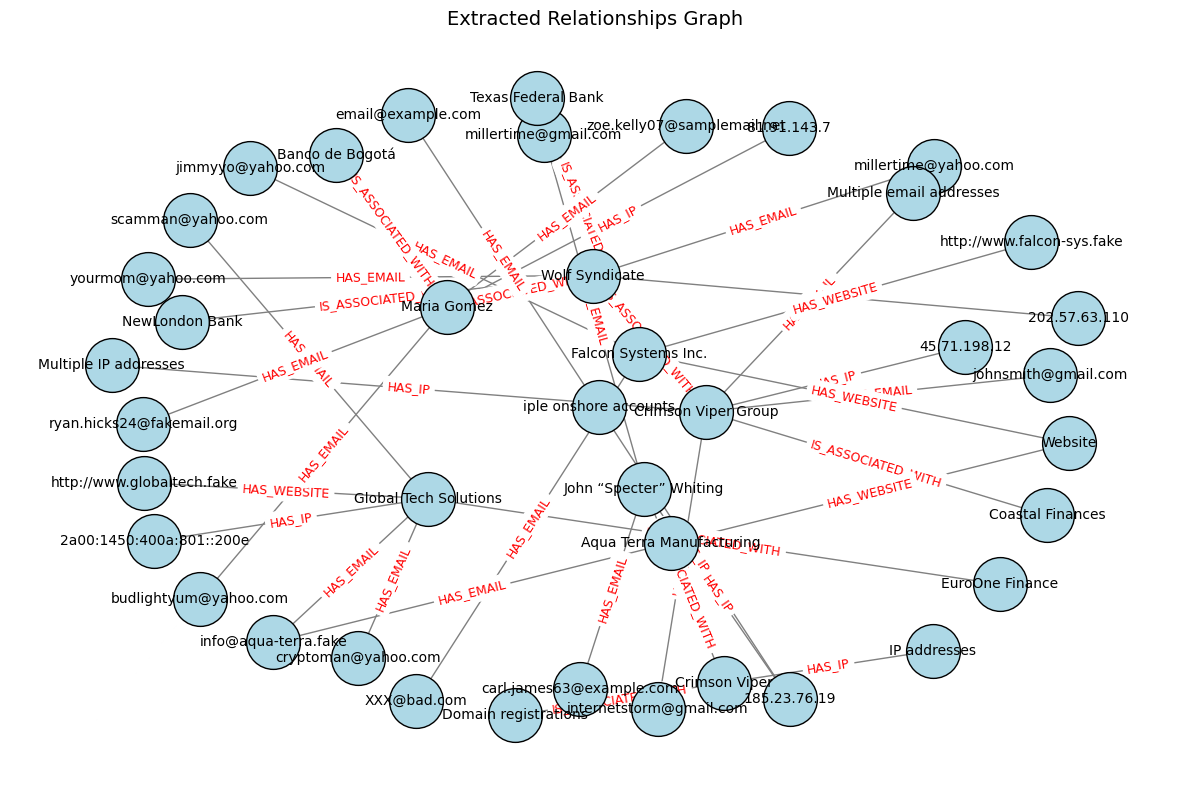

INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 0 IPs, 3 emails, and 0 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 1 IPs, 5 emails, and 2 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 1 IPs, 4 emails, and 1 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.apim.mitre.org/api-key/openai/deployments/gpt35-turbo-16k/chat/completions?api-version=2023-03-15-preview "HTTP/1.1 200 OK"
INFO:__main__:Extracted 4 IPs, 4 emails, and 1 person names from chunk.
INFO:httpx:HTTP Request: POST https://aoai.a

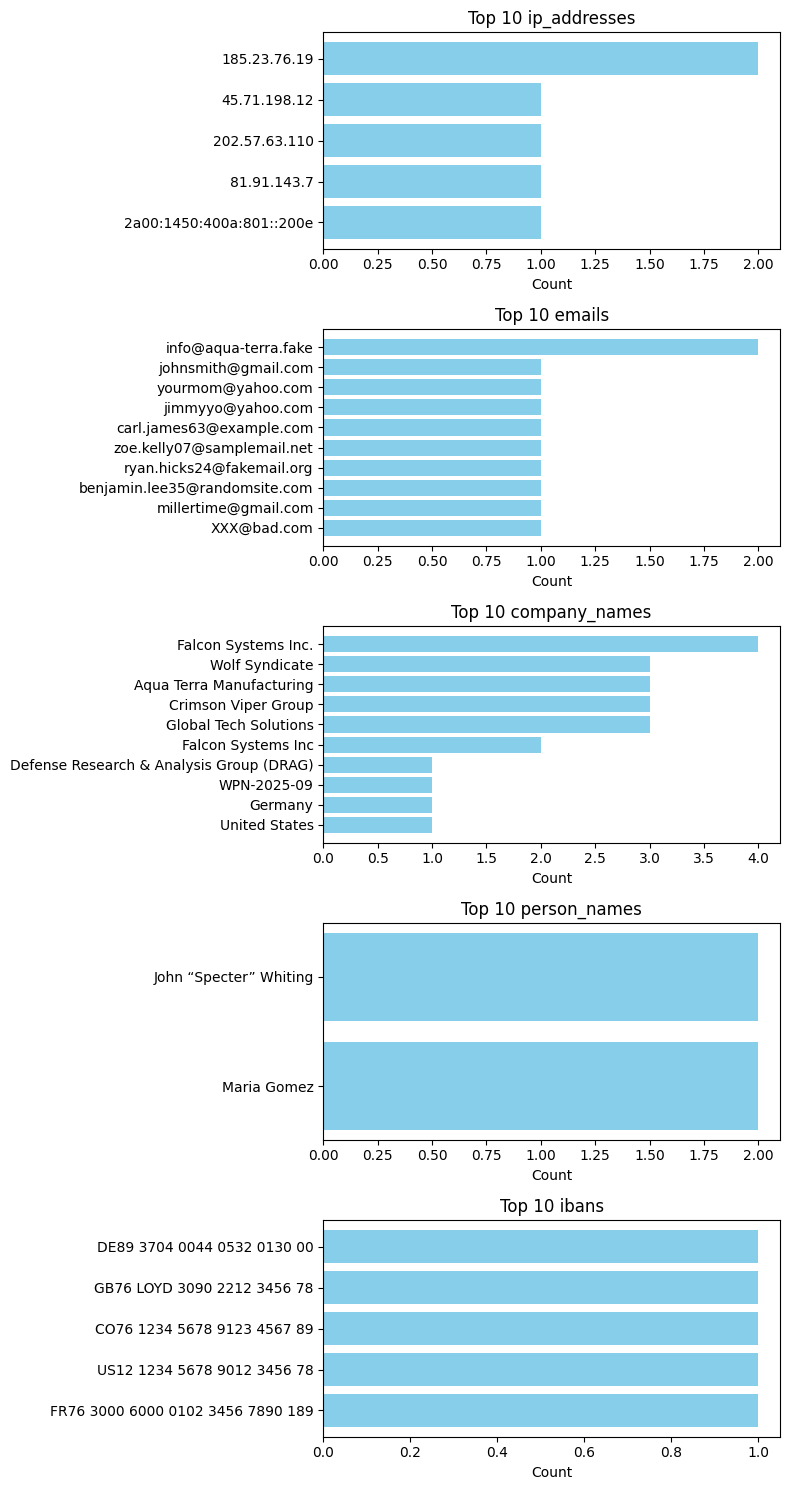

In [56]:
# Usage Example
# ---------------------------------------
if __name__ == "__main__":
    from openai import AzureOpenAI

    openai_client = AzureOpenAI(
        azure_endpoint=AZURE_ENDPOINT,
        api_key=AZURE_API_KEY,
        default_headers={"Content-Type": "application/json"},
        api_version=API_VERSION,
    )

    pdf_file_path = "/Users/bdowns/tflima/FakePDF.pdf"
    entities, relationships, chunks = extract_data_from_pdf(pdf_file_path, openai_client, max_chars=1500)

    logger.info("Extracted Entities:")
    logger.info(json.dumps(entities, indent=2))
    logger.info("Extracted Relationships:")
    logger.info(json.dumps(relationships, indent=2))

    save_entities_to_csv(entities, "extracted_entities.csv")
    save_relationships_to_csv(relationships, "extracted_relationships.csv")

    # Visualize relationships graph
    visualize_relationships(relationships)

    # Aggregate frequency counts and visualize top entities
    aggregated_counts = aggregate_entities_with_counts(chunks, openai_client)
    visualize_top_entities(aggregated_counts, top_n=10)